In [1]:
import ipyparallel as ipp
cluster = ipp.Cluster(engines="mpi", n=2)
rc = cluster.start_and_connect_sync()

Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/2 [00:00<?, ?engine/s]

In [5]:
%%px
from mpi4py import MPI
import numpy as np

print(f"{MPI.COMM_WORLD.rank=} {MPI.COMM_WORLD.size=}")

[stdout:1] MPI.COMM_WORLD.rank=1 MPI.COMM_WORLD.size=2


[stdout:0] MPI.COMM_WORLD.rank=0 MPI.COMM_WORLD.size=2


In [7]:
import gmsh
import os
import numpy as np
import matplotlib.pyplot as plt
import tqdm.autonotebook

from mpi4py import MPI
from petsc4py import PETSc

from basix.ufl import element

from dolfinx.cpp.mesh import to_type, cell_entity_type
from dolfinx.fem import (Constant, Function, functionspace,
                         assemble_scalar, dirichletbc, form, locate_dofs_topological, set_bc)
from dolfinx.fem.petsc import (apply_lifting, assemble_matrix, assemble_vector,
                               create_vector, create_matrix, set_bc)
from dolfinx.graph import adjacencylist
from dolfinx.geometry import bb_tree, compute_collisions_points, compute_colliding_cells
from dolfinx.io import (VTXWriter, distribute_entity_data, gmshio)
from dolfinx.mesh import create_mesh, meshtags_from_entities, locate_entities_boundary
from ufl import (FacetNormal, Identity, Measure, TestFunction, TrialFunction,
                 as_vector, div, dot, ds, dx, inner, lhs, grad, nabla_grad, rhs, sym, system)

gmsh.initialize()

L = 2.2
H = 0.41
c_x = c_y = 0.41
r = 0.05
gdim = 2
mesh_comm = MPI.COMM_WORLD
model_rank = 0
if mesh_comm.rank == model_rank:
    rectangle = gmsh.model.occ.addRectangle(0, 0, 0, L, H, tag=1)
    obstacle = gmsh.model.occ.addDisk(c_x, c_y, 0, r, r)

In [8]:
if mesh_comm.rank == model_rank:
    fluid = gmsh.model.occ.cut([(gdim, rectangle)], [(gdim, obstacle)])
    gmsh.model.occ.synchronize()

In [9]:
fluid_marker = 1
if mesh_comm.rank == model_rank:
    volumes = gmsh.model.getEntities(dim=gdim)
    assert (len(volumes) == 1)
    gmsh.model.addPhysicalGroup(volumes[0][0], [volumes[0][1]], fluid_marker)
    gmsh.model.setPhysicalName(volumes[0][0], fluid_marker, "Fluid")

In [17]:
inlet_marker, outlet_marker, wall_marker, obstacle_marker = 2, 3, 4, 5
inflow, outflow, walls, obstacle = [], [], [], []
if mesh_comm.rank == model_rank:
    boundaries = gmsh.model.getBoundary(volumes, oriented=False)
    for boundary in boundaries:
        center_of_mass = gmsh.model.occ.getCenterOfMass(boundary[0], boundary[1])
        if np.allclose(center_of_mass, [0, H / 2, 0]):
            inflow.append(boundary[1])
        elif np.allclose(center_of_mass, [L, H / 2, 0]):
            outflow.append(boundary[1])
        elif np.allclose(center_of_mass, [L / 2, H, 0]) or np.allclose(center_of_mass, [L / 2, 0, 0]):
            walls.append(boundary[1])
        else:
            obstacle.append(boundary[1])
    gmsh.model.addPhysicalGroup(1, walls, wall_marker)
    gmsh.model.setPhysicalName(1, wall_marker, "Walls")
    gmsh.model.addPhysicalGroup(1, inflow, inlet_marker)
    gmsh.model.setPhysicalName(1, inlet_marker, "Inlet")
    gmsh.model.addPhysicalGroup(1, outflow, outlet_marker)
    gmsh.model.setPhysicalName(1, outlet_marker, "Outlet")
    gmsh.model.addPhysicalGroup(1, obstacle, obstacle_marker)
    gmsh.model.setPhysicalName(1, obstacle_marker, "Obstacle")

In [18]:
# Create distance field from obstacle.
# Add threshold of mesh sizes based on the distance field
# LcMax -                  /--------
#                      /
# LcMin -o---------/
#        |         |       |
#       Point    DistMin DistMax
res_min = r / 3
if mesh_comm.rank == model_rank:
    distance_field = gmsh.model.mesh.field.add("Distance")
    gmsh.model.mesh.field.setNumbers(distance_field, "EdgesList", obstacle)
    threshold_field = gmsh.model.mesh.field.add("Threshold")
    gmsh.model.mesh.field.setNumber(threshold_field, "IField", distance_field)
    gmsh.model.mesh.field.setNumber(threshold_field, "LcMin", res_min)
    # gmsh.model.mesh.field.setNumber(threshold_field, "LcMax", 0.25 * H)
    # gmsh.model.mesh.field.setNumber(threshold_field, "DistMin", r)
    # gmsh.model.mesh.field.setNumber(threshold_field, "DistMax", 2 * H)
    min_field = gmsh.model.mesh.field.add("Min")
    gmsh.model.mesh.field.setNumbers(min_field, "FieldsList", [threshold_field])
    gmsh.model.mesh.field.setAsBackgroundMesh(min_field)

In [19]:
gmsh.option.setNumber?

Signature: gmsh.option.setNumber(name, value)
Docstring:
gmsh.option.setNumber(name, value)

Set a numerical option to `value'. `name' is of the form "Category.Option"
or "Category[num].Option". Available categories and options are listed in
the "Gmsh options" chapter of the Gmsh reference manual
(https://gmsh.info/doc/texinfo/gmsh.html#Gmsh-options).

Types:
- `name': string
- `value': double
File:      /usr/local/lib/gmsh.py
Type:      function

In [20]:
if mesh_comm.rank == model_rank:
    gmsh.option.setNumber("Mesh.Algorithm", 8)
    gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 2)
    gmsh.option.setNumber("Mesh.RecombineAll", 1)
    gmsh.option.setNumber("Mesh.SubdivisionAlgorithm", 1)
    gmsh.model.mesh.generate(gdim)
    gmsh.model.mesh.setOrder(2)
    gmsh.model.mesh.optimize("Netgen")

Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay for Quads)
Info    : Simple recombination completed (Wall 0.00771483s, CPU 0.007714s): 354 quads, 88 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.730261, min Q = 0.318493
Info    : Simple recombination completed (Wall 0.0158881s, CPU 0.015957s): 1680 quads, 0 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.802809, min Q = 0.294125
Info    : Done meshing 2D (Wall 0.0357396s, CPU 0.036787s)
Info    : Refining mesh...
Info    : Meshing order 2 (curvilinear on)...
Info    : [  0%] Meshing curve 1 order 2
Info    : [ 20%] Meshing curve 2 order 2
Info    : [ 30%] Meshing curve 3 order 2
Info    : [ 50%] Meshing curve 4 order 2
Info    : [ 60%] Meshing curve 5 order 2
Info    : [ 80%] Meshing curve 6 order 2
Info    : [ 90%] Meshing surface 1 order 2
Info    : Done meshing order 2 (Wall 0.00657927s, CPU 0.006744s)
Info    : Done refining mesh (Wall 0.00737253s, CPU 0.007563s)
Info    : 6793

In [21]:
mesh, _, ft = gmshio.model_to_mesh(gmsh.model, mesh_comm, model_rank, gdim=gdim)
ft.name = "Facet markers"

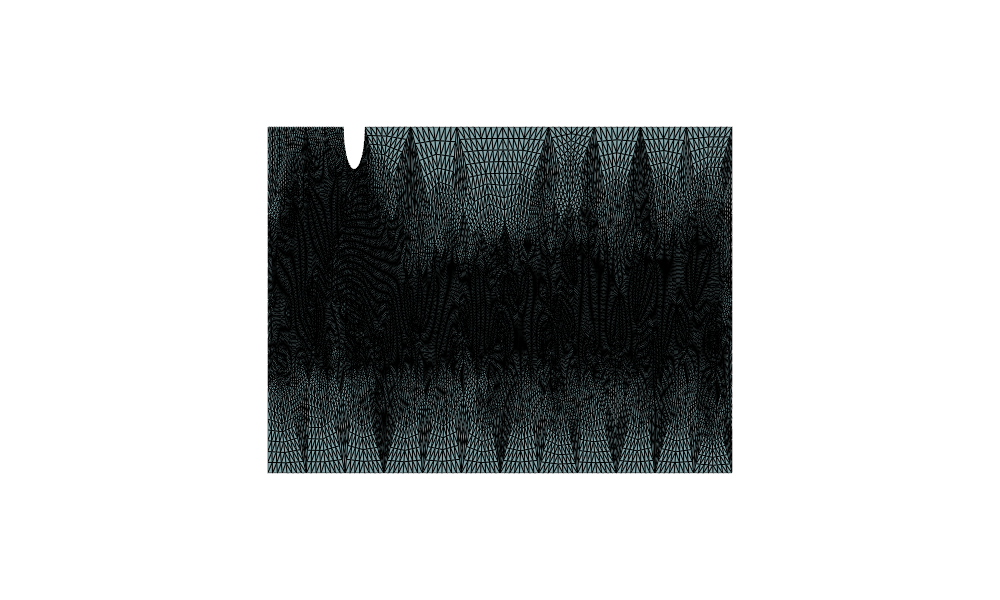

In [22]:
from dolfinx.plot import vtk_mesh
import pyvista
pyvista.start_xvfb()
tdim = mesh.topology.dim
topology, cell_types, geometry = vtk_mesh(mesh, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter()
plotter.window_size = [1000, 600]
plotter.set_scale(yscale=4)
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()

if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    pyvista.start_xvfb()
    figure = plotter.screenshot("fundamentals_mesh.png")

In [23]:
t = 0
T = 8                       # Final time
dt = 1 / 500 #1600                 # Time step size
num_steps = int(T / dt)
k = Constant(mesh, PETSc.ScalarType(dt))
mu = Constant(mesh, PETSc.ScalarType(0.001))  # Dynamic viscosity
rho = Constant(mesh, PETSc.ScalarType(1))     # Density

In [24]:
v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim, ))
s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
V = functionspace(mesh, v_cg2)
Q = functionspace(mesh, s_cg1)

fdim = mesh.topology.dim - 1

# Define boundary conditions


class InletVelocity():
    def __init__(self, t):
        self.t = t

    def __call__(self, x):
        values = np.zeros((gdim, x.shape[1]), dtype=PETSc.ScalarType)
        values[0] = 4 * 1.5 * np.sin(self.t * np.pi / 8) * x[1] * (0.41 - x[1]) / (0.41**2)
        return values


# Inlet
u_inlet = Function(V)
inlet_velocity = InletVelocity(t)
u_inlet.interpolate(inlet_velocity)
bcu_inflow = dirichletbc(u_inlet, locate_dofs_topological(V, fdim, ft.find(inlet_marker)))
# Walls
u_nonslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)
bcu_walls = dirichletbc(u_nonslip, locate_dofs_topological(V, fdim, ft.find(wall_marker)), V)
# Obstacle
bcu_obstacle = dirichletbc(u_nonslip, locate_dofs_topological(V, fdim, ft.find(obstacle_marker)), V)
bcu = [bcu_inflow, bcu_obstacle, bcu_walls]
# Outlet
bcp_outlet = dirichletbc(PETSc.ScalarType(0), locate_dofs_topological(Q, fdim, ft.find(outlet_marker)), Q)
bcp = [bcp_outlet]

In [25]:
u = TrialFunction(V)
v = TestFunction(V)
u_ = Function(V)
u_.name = "u"
u_s = Function(V)
u_n = Function(V)
u_n1 = Function(V)
p = TrialFunction(Q)
q = TestFunction(Q)
p_ = Function(Q)
p_.name = "p"
phi = Function(Q)

In [26]:
f = Constant(mesh, PETSc.ScalarType((0, 0)))
F1 = rho / k * dot(u - u_n, v) * dx
F1 += inner(dot(1.5 * u_n - 0.5 * u_n1, 0.5 * nabla_grad(u + u_n)), v) * dx
F1 += 0.5 * mu * inner(grad(u + u_n), grad(v)) * dx - dot(p_, div(v)) * dx
F1 += dot(f, v) * dx
a1 = form(lhs(F1))
L1 = form(rhs(F1))
A1 = create_matrix(a1)
b1 = create_vector(L1)

In [27]:
a2 = form(dot(grad(p), grad(q)) * dx)
L2 = form(-rho / k * dot(div(u_s), q) * dx)
A2 = assemble_matrix(a2, bcs=bcp)
A2.assemble()
b2 = create_vector(L2)

In [28]:
a3 = form(rho * dot(u, v) * dx)
L3 = form(rho * dot(u_s, v) * dx - k * dot(nabla_grad(phi), v) * dx)
A3 = assemble_matrix(a3)
A3.assemble()
b3 = create_vector(L3)

In [29]:
# Solver for step 1
solver1 = PETSc.KSP().create(mesh.comm)
solver1.setOperators(A1)
solver1.setType(PETSc.KSP.Type.BCGS)
pc1 = solver1.getPC()
pc1.setType(PETSc.PC.Type.JACOBI)

# Solver for step 2
solver2 = PETSc.KSP().create(mesh.comm)
solver2.setOperators(A2)
solver2.setType(PETSc.KSP.Type.MINRES)
pc2 = solver2.getPC()
pc2.setType(PETSc.PC.Type.HYPRE)
pc2.setHYPREType("boomeramg")

# Solver for step 3
solver3 = PETSc.KSP().create(mesh.comm)
solver3.setOperators(A3)
solver3.setType(PETSc.KSP.Type.CG)
pc3 = solver3.getPC()
pc3.setType(PETSc.PC.Type.SOR)

In [30]:
n = -FacetNormal(mesh)  # Normal pointing out of obstacle
dObs = Measure("ds", domain=mesh, subdomain_data=ft, subdomain_id=obstacle_marker)
u_t = inner(as_vector((n[1], -n[0])), u_)
drag = form(2 / 0.1 * (mu / rho * inner(grad(u_t), n) * n[1] - p_ * n[0]) * dObs)
lift = form(-2 / 0.1 * (mu / rho * inner(grad(u_t), n) * n[0] + p_ * n[1]) * dObs)
if mesh.comm.rank == 0:
    C_D = np.zeros(num_steps, dtype=PETSc.ScalarType)
    C_L = np.zeros(num_steps, dtype=PETSc.ScalarType)
    t_u = np.zeros(num_steps, dtype=np.float64)
    t_p = np.zeros(num_steps, dtype=np.float64)

In [31]:
tree = bb_tree(mesh, mesh.geometry.dim)
points = np.array([[0.15, 0.2, 0], [0.25, 0.2, 0]])
cell_candidates = compute_collisions_points(tree, points)
colliding_cells = compute_colliding_cells(mesh, cell_candidates, points)
front_cells = colliding_cells.links(0)
back_cells = colliding_cells.links(1)
if mesh.comm.rank == 0:
    p_diff = np.zeros(num_steps, dtype=PETSc.ScalarType)

In [32]:
from pathlib import Path
folder = Path("results")
folder.mkdir(exist_ok=True, parents=True)
vtx_u = VTXWriter(mesh.comm, "dfg2D-3-u.bp", [u_], engine="BP4")
vtx_p = VTXWriter(mesh.comm, "dfg2D-3-p.bp", [p_], engine="BP4")
vtx_u.write(t)
vtx_p.write(t)
progress = tqdm.autonotebook.tqdm(desc="Solving PDE", total=num_steps)
for i in range(num_steps):
    progress.update(1)
    # Update current time step
    t += dt
    # Update inlet velocity
    inlet_velocity.t = t
    u_inlet.interpolate(inlet_velocity)

    # Step 1: Tentative velocity step
    A1.zeroEntries()
    assemble_matrix(A1, a1, bcs=bcu)
    A1.assemble()
    with b1.localForm() as loc:
        loc.set(0)
    assemble_vector(b1, L1)
    apply_lifting(b1, [a1], [bcu])
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b1, bcu)
    solver1.solve(b1, u_s.vector)
    u_s.x.scatter_forward()

    # Step 2: Pressure corrrection step
    with b2.localForm() as loc:
        loc.set(0)
    assemble_vector(b2, L2)
    apply_lifting(b2, [a2], [bcp])
    b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b2, bcp)
    solver2.solve(b2, phi.vector)
    phi.x.scatter_forward()

    p_.vector.axpy(1, phi.vector)
    p_.x.scatter_forward()

    # Step 3: Velocity correction step
    with b3.localForm() as loc:
        loc.set(0)
    assemble_vector(b3, L3)
    b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    solver3.solve(b3, u_.vector)
    u_.x.scatter_forward()

    # Write solutions to file
    vtx_u.write(t)
    vtx_p.write(t)

    # Update variable with solution form this time step
    with u_.vector.localForm() as loc_, u_n.vector.localForm() as loc_n, u_n1.vector.localForm() as loc_n1:
        loc_n.copy(loc_n1)
        loc_.copy(loc_n)

    # Compute physical quantities
    # For this to work in paralell, we gather contributions from all processors
    # to processor zero and sum the contributions.
    drag_coeff = mesh.comm.gather(assemble_scalar(drag), root=0)
    lift_coeff = mesh.comm.gather(assemble_scalar(lift), root=0)
    p_front = None
    if len(front_cells) > 0:
        p_front = p_.eval(points[0], front_cells[:1])
    p_front = mesh.comm.gather(p_front, root=0)
    p_back = None
    if len(back_cells) > 0:
        p_back = p_.eval(points[1], back_cells[:1])
    p_back = mesh.comm.gather(p_back, root=0)
    if mesh.comm.rank == 0:
        t_u[i] = t
        t_p[i] = t - dt / 2
        C_D[i] = sum(drag_coeff)
        C_L[i] = sum(lift_coeff)
        # Choose first pressure that is found from the different processors
        for pressure in p_front:
            if pressure is not None:
                p_diff[i] = pressure[0]
                break
        for pressure in p_back:
            if pressure is not None:
                p_diff[i] -= pressure[0]
                break
vtx_u.close()
vtx_p.close()

Solving PDE:   0%|          | 0/4000 [00:00<?, ?it/s]

In [33]:
u_sub = u_n.sub(0)  # Normal component of velocity (u_x in 2D)

# Define a function space on the boundary (or use a test function for the integral)
dx = Measure("dx", domain=V.mesh)

# Define the mass flow rate as an integral over the boundary
mass_flow_rate = assemble_scalar(form(u_sub * dx))

# Print the result (using MPI reduce for distributed computation)
mass_flow_rate_global = MPI.COMM_WORLD.reduce(mass_flow_rate, op=MPI.SUM, root=0)
if MPI.COMM_WORLD.rank == 0:
    print("Mass flow rate:", mass_flow_rate_global)
# first run: -3.6759450075933575e-09
# second run: 3.005493520227765e-09

Mass flow rate: 3.005493520227765e-09


In [29]:
u_n.sub(0).x.x

Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, quadrilateral, 2, equispaced, unset, False, float64, []), (2,)), 0), Basix element (P, quadrilateral, 2, gll_warped, unset, False, float64, [])), 7)

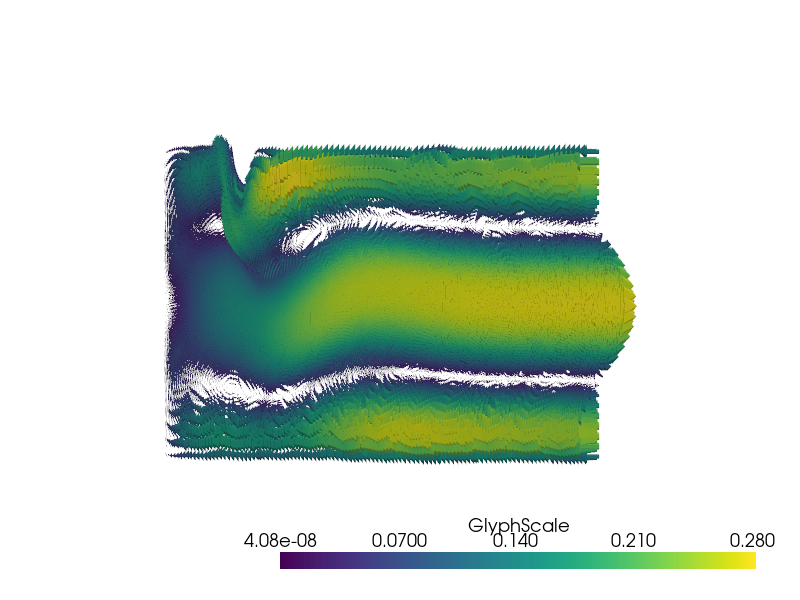

In [34]:
pyvista.start_xvfb()
topology, cell_types, geometry = vtk_mesh(V)
values = np.zeros((geometry.shape[0], 3), dtype=np.float64)
values[:, :len(u_n)] = u_n.x.array.real.reshape((geometry.shape[0], len(u_n)))

# Create a point cloud of glyphs
function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
function_grid["u"] = values
glyphs = function_grid.glyph(orient="u", factor=0.7)

# Create a pyvista-grid for the mesh
#mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim)
#grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh, mesh.topology.dim))

# Create plotter
plotter = pyvista.Plotter()
#plotter.add_mesh(grid, style="wireframe", color="k")
plotter.add_mesh(glyphs)
plotter.window_size = [800, 600]
plotter.set_scale(yscale=4)
plotter.view_xy()
plotter.save_graphic("glyphs2.pdf",title='PyVista Export')
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    fig_as_array = plotter.screenshot("glyphs3.pdf")

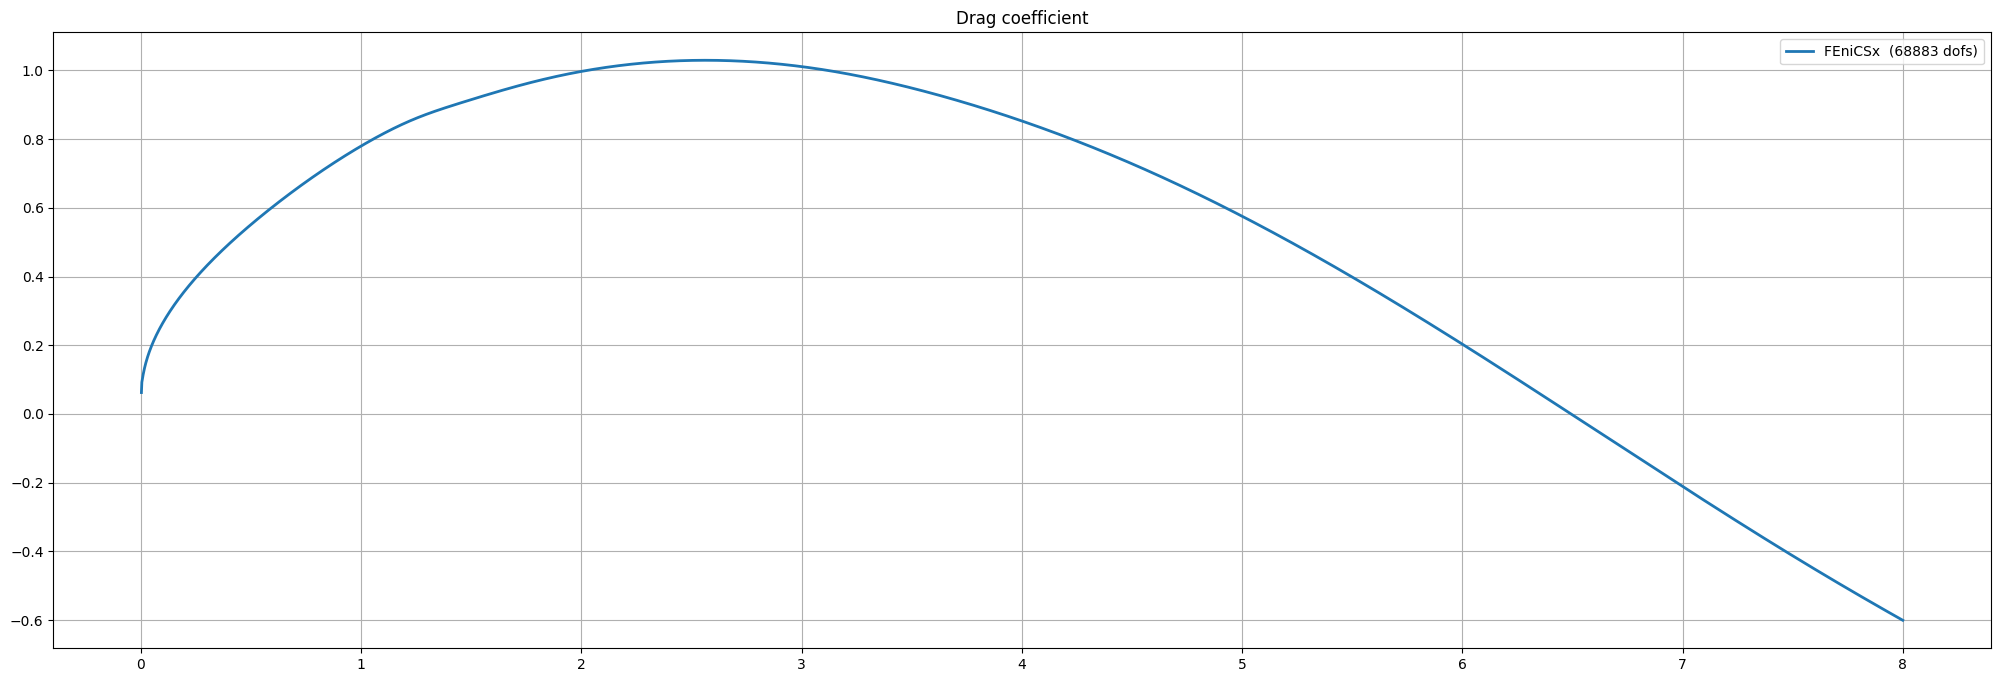

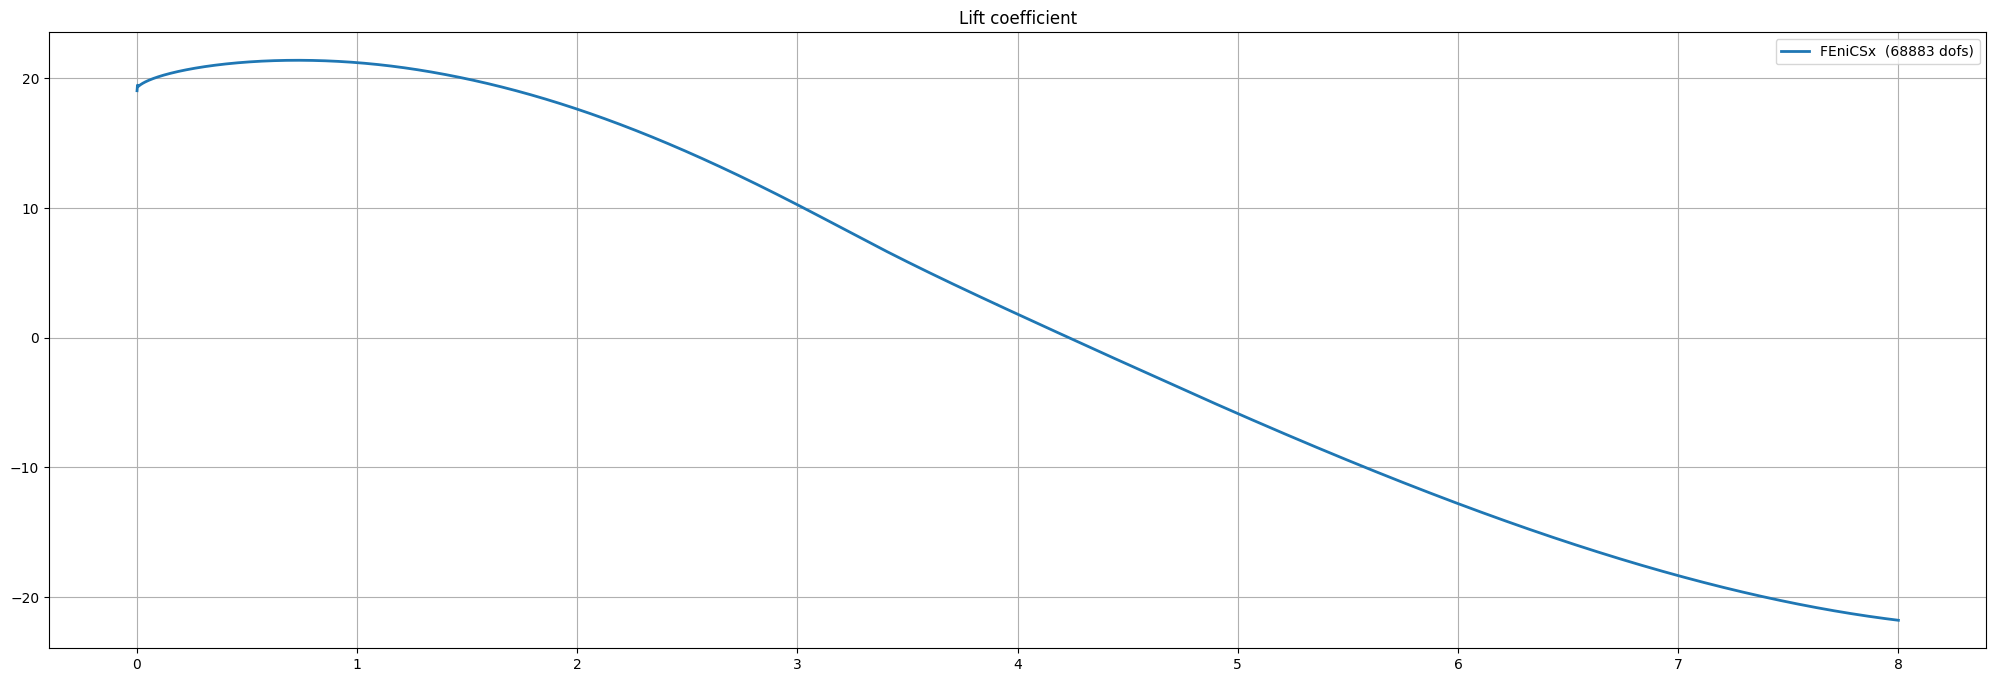

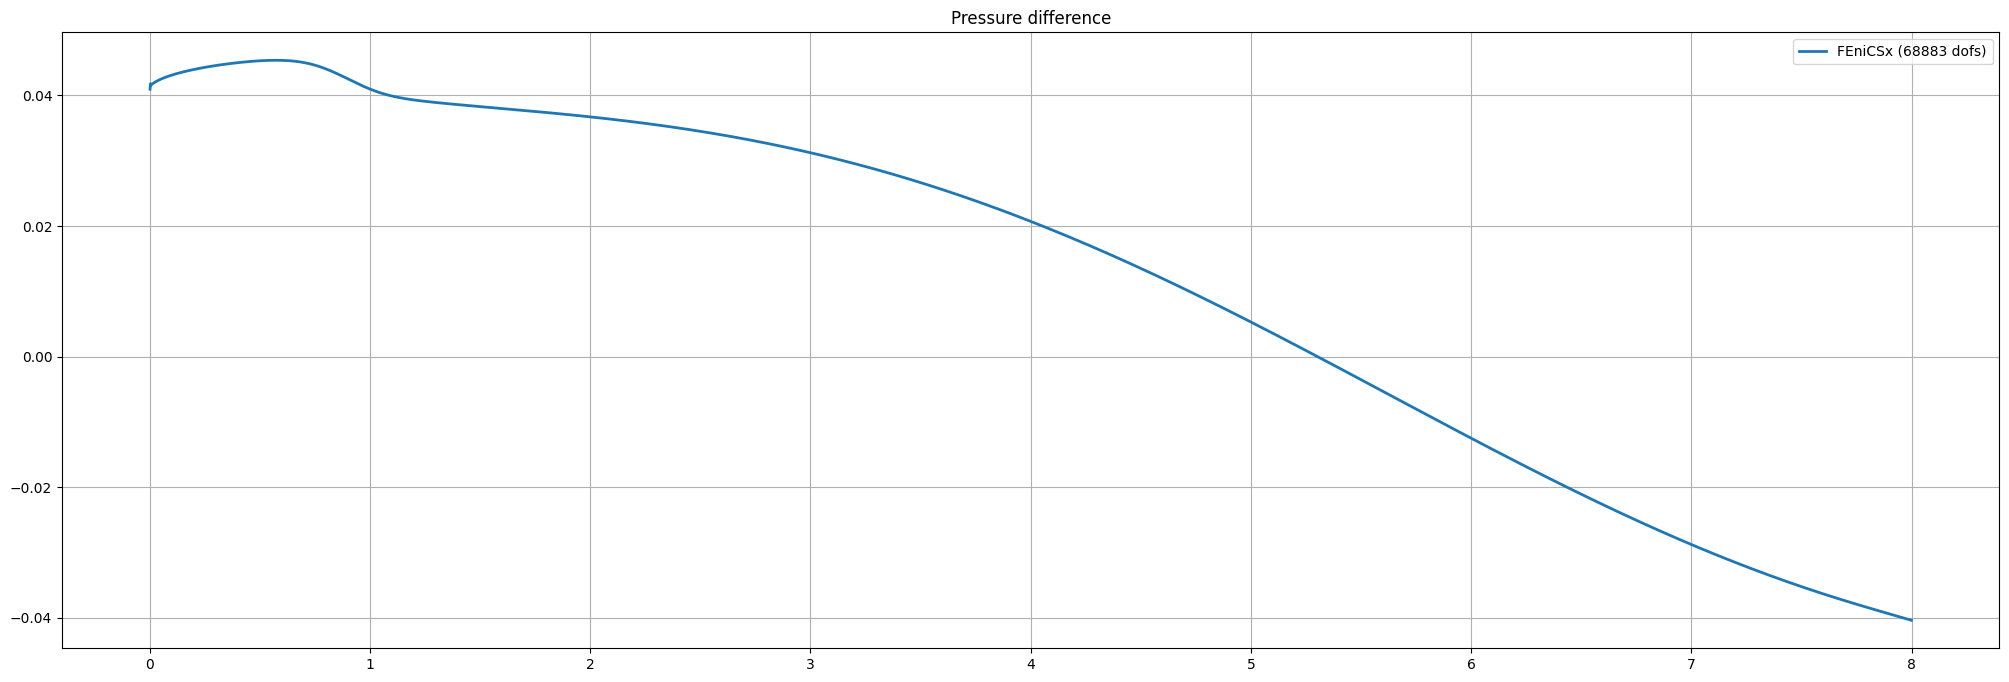

In [20]:
# if mesh.comm.rank == 0:
#     if not os.path.exists("figures"):
#         os.mkdir("figures")
#     num_velocity_dofs = V.dofmap.index_map_bs * V.dofmap.index_map.size_global
#     num_pressure_dofs = Q.dofmap.index_map_bs * V.dofmap.index_map.size_global

#     #turek = np.loadtxt("bdforces_lv4")
#     #turek_p = np.loadtxt("pointvalues_lv4")
#     fig = plt.figure(figsize=(25, 8))
#     l1 = plt.plot(t_u, C_D, label=r"FEniCSx  ({0:d} dofs)".format(num_velocity_dofs + num_pressure_dofs), linewidth=2)
#     #l2 = plt.plot(turek[1:, 1], turek[1:, 3], marker="x", markevery=50,
#     #              linestyle="", markersize=4, label="FEATFLOW (42016 dofs)")
#     plt.title("Drag coefficient")
#     plt.grid()
#     plt.legend()
#     plt.savefig("figures/drag.png")

#     fig = plt.figure(figsize=(25, 8))
#     l1 = plt.plot(t_u, C_L, label=r"FEniCSx  ({0:d} dofs)".format(
#         num_velocity_dofs + num_pressure_dofs), linewidth=2)
#     #l2 = plt.plot(turek[1:, 1], turek[1:, 4], marker="x", markevery=50,
#     #              linestyle="", markersize=4, label="FEATFLOW (42016 dofs)")
#     plt.title("Lift coefficient")
#     plt.grid()
#     plt.legend()
#     plt.savefig("figures/lift.png")

#     fig = plt.figure(figsize=(25, 8))
#     l1 = plt.plot(t_p, p_diff, label=r"FEniCSx ({0:d} dofs)".format(num_velocity_dofs + num_pressure_dofs), linewidth=2)
#     #l2 = plt.plot(turek[1:, 1], turek_p[1:, 6] - turek_p[1:, -1], marker="x", markevery=50,
#     #              linestyle="", markersize=4, label="FEATFLOW (42016 dofs)")
#     plt.title("Pressure difference")
#     plt.grid()
#     plt.legend()
#     plt.savefig("figures/pressure.png")